In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
path = "/content/drive/MyDrive/code/WZ"
os.chdir(path)
print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/code/WZ'

In [1]:
import importlib
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

from collections import deque


sizef = 8

In [2]:
class Gomoku:
    def __init__(self, size=sizef, black_strategy=None, white_strategy=None):
        self.size = size  # 棋盘大小
        self.board = [['.' for _ in range(size)] for _ in range(size)]  # 初始化棋盘
        self.current_player = 'X'  # 当前玩家 ('X' or 'O')
        self.black_strategy = black_strategy  # 黑棋策略函数
        self.white_strategy = white_strategy  # 白棋策略函数

    def display_board(self):
        """打印棋盘"""
        print("   " + " ".join(f"{i:2}" for i in range(self.size)))
        for i, row in enumerate(self.board):
            print(f"{i:2} " + " ".join(row))

    def is_valid_move(self, x, y):
        """检查落子是否合法"""
        return 0 <= x < self.size and 0 <= y < self.size and self.board[x][y] == '.'

    def make_move(self, x, y):
        """下棋"""
        if self.is_valid_move(x, y):
            self.board[x][y] = self.current_player
            return True
        else:
            print(f"Invalid move by player {self.current_player} at ({x}, {y}).")
            return False

    def check_winner(self, x, y):
        """检查当前玩家是否获胜"""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # 四个方向：水平、垂直、正斜线、反斜线
        for dx, dy in directions:
            count = 1
            # 检查正方向
            for step in range(1, 5):
                nx, ny = x + step * dx, y + step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            # 检查反方向
            for step in range(1, 5):
                nx, ny = x - step * dx, y - step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            if count >= 5:  # 连续五子
                return True
        return False

    def switch_player(self):
        """切换玩家"""
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    def play(self):
        """游戏主循环"""
        print("Starting Gomoku!")
        self.display_board()

        # 检查是否有 GPU 可用
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Running on device: {device}")

        while True:
            if self.current_player == 'X':
                if self.black_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.black_strategy(self.board, 'X', device=device)
                else:
                    move = self.get_human_move()
            else:
                if self.white_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.white_strategy(self.board, 'O', device=device)
                else:
                    move = self.get_human_move()

            if not move or len(move) != 2:
                print(f"Invalid move returned by player {self.current_player}.")
                break

            x, y = move
            if self.make_move(x, y):
                print(f"Player {self.current_player} places at ({x}, {y})")
                self.display_board()
                if self.check_winner(x, y):
                    print(f"Player {self.current_player} wins!")
                    break
                self.switch_player()
            else:
                print("Game Over due to invalid move.")
                break

        print("Game Over!")

    def get_human_move(self):
        """获取玩家的落子"""
        while True:
            try:
                move = input(f"Player {self.current_player}, enter your move (row col): ").strip()
                x, y = map(int, move.split())
                if self.is_valid_move(x, y):
                    return x, y
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Please enter row and column numbers separated by a space.")


def load_strategy(file_name):
    """从本地文件加载策略"""
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"Strategy file {file_name} not found.")

    module_name = os.path.splitext(os.path.basename(file_name))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.play  # 假设策略文件中定义了一个 play 函数



def print_strategy_files(directory):
    try:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith("strategy.py"):
                    print(file)
    except Exception as e:
        print(f"Invaid: {e}")

In [3]:
print("Welcome to Gomoku!")
print("Choose game mode:")
print("1. Human vs AI")
print("2. AI vs AI")
mode = input("Enter 1 or 2: ").strip()

black_strategy = None
white_strategy = None

if mode == "1":
    print("You will play as 'X'.")
    print_strategy_files(os.getcwd())
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    white_strategy = load_strategy(white_strategy_file)
elif mode == "2":
    print_strategy_files(os.getcwd())
    black_strategy_file = input("Enter the AI strategy file for 'X' (e.g., black_strategy.py): ").strip()
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    black_strategy = load_strategy(black_strategy_file)
    white_strategy = load_strategy(white_strategy_file)
else:
    print("Invalid choice. Exiting.")

game = Gomoku(black_strategy=black_strategy, white_strategy=white_strategy)
game.play()

Welcome to Gomoku!
Choose game mode:
1. Human vs AI
2. AI vs AI


KeyboardInterrupt: Interrupted by user

In [3]:
from alpha0v2_strategy_v2 import AlphaZeroNet
from alpha0v2_strategy_v2 import MCTS

In [4]:
# ------------------------------
# Data Generation via Self-Play
# ------------------------------
def self_play_game(model, board_size, mcts_simulations=5):
    """Generate training data via self-play"""
    # 检查是否有 GPU 并将模型移动到 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 初始化棋盘和 MCTS
    board = [['.' for _ in range(board_size)] for _ in range(board_size)]
    mcts = MCTS(model, board_size)
    current_player = 'X'
    last_move = None
    game_data = []  # Store (state, policy, value) for training
    winner = None

    while True:

        # Run MCTS to get the move and actions
        move, actions = mcts.run(board, current_player, mcts_simulations, last_move=last_move)

        # Step 1: 提取所有 (action, Q + u) 对
        action_values = [(action, node.get_value(c_puct=5.0)) for action, node in actions.items()]

        # Step 2: 计算所有 (Q + u) 的 softmax 概率
        values = np.array([value for _, value in action_values])
        exp_values = np.exp(values - np.max(values))  # 稳定的 softmax 计算
        probabilities = exp_values / np.sum(exp_values)

        # Step 3: 生成结果数组
        action_probs = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
        
        state = mcts.board_to_tensor(board, current_player, last_move).squeeze(0).detach().cpu().numpy()

        # Make the move
        board = mcts.make_move(board, move, current_player)

        # Store state and policy
#         state = np.zeros((4, board_size, board_size))

#         # 当前玩家的棋子位置
#         for x in range(board_size):
#             for y in range(board_size):
#                 if board[x][y] == current_player:
#                     state[0][x][y] = 1.0
#                 elif board[x][y] != '.':  # 对手的棋子位置
#                     state[1][x][y] = 1.0

#         # 最近一次落子的位置
#         if last_move is not None:
#             state[2][last_move[0]][last_move[1]] = 1.0

#         # 当前轮到谁下棋
#         if current_player == 'O':  # 如果是偶数回合，轮到白棋
#             state[3][:, :] = 1.0

        # 更新 last_move
        last_move = move

        # 转换动作概率
        action_probs_np = np.zeros((board_size, board_size))
        for (x, y), prob in action_probs:
            action_probs_np[x, y] = prob

        # 检查胜利条件
        if mcts.check_winner(board, current_player):
            winner = current_player
            game_data.append([state, action_probs_np, 1 if winner == 'X' else -1])
            break

        # 检查平局
        if not mcts.get_legal_moves(board):
            winner = None  # Draw
            game_data.append([state, action_probs_np, 0])
            break

        # 切换玩家
        current_player = 'O' if current_player == 'X' else 'X'

    return game_data

In [5]:
def compute_softmax_probabilities(children):
    # Step 1: 提取所有 (action, value_sum) 对
    action_values = [(action, node.value_sum) for action, node in children.items()]

    # Step 2: 计算所有 value_sum 的 softmax 概率
    values = np.array([value_sum for _, value_sum in action_values])
    exp_values = np.exp(values - np.max(values))
    probabilities = exp_values / np.sum(exp_values)

    # Step 3: 生成结果数组
    result = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
    return result




In [6]:
def train_alphazero(model, white_strategy, board_size, iterations=100, games_per_iteration=10, 
                    batch_size=32, mcts_simulations=100, alpha=0.5, l2_lambda=1e-4, entropy_alpha=1e-3):
    """Train AlphaZero model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU if available
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    replay_buffer = deque(maxlen=10000)  # Replay buffer to store training data
    loss_fn_policy = nn.CrossEntropyLoss()
    loss_fn_value = nn.MSELoss()

    policy_loss_list = []
    value_loss_list = []
    results_list = [] 

    for iteration in range(iterations):
        # Generate self-play data
        for _ in range(games_per_iteration):
            game_data = self_play_game(model, board_size, mcts_simulations)
            replay_buffer.extend(game_data)
        
        # Sample a batch from replay buffer
        if len(replay_buffer) < batch_size:
            continue

        batch = random.sample(replay_buffer, batch_size)
        states, policies, values = zip(*batch)

        # Move data to GPU
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
        policies = torch.tensor(np.stack(policies), dtype=torch.float32).view(batch_size, 
                                                        board_size * board_size).to(device)
        values = torch.tensor(values, dtype=torch.float32).view(-1, 1).to(device)

        # Forward pass
        pred_policies, pred_values = model(states)

        # Compute losses
        policy_loss = loss_fn_policy(pred_policies, policies)
        value_loss = loss_fn_value(pred_values, values)

        l2_reg = sum(param.pow(2).sum() for param in model.parameters())
        #entropy = -torch.sum(pred_policies * torch.log(pred_policies + 1e-8), dim=1).mean()

        loss = (policy_loss * alpha + value_loss * (1 - alpha)
                + l2_lambda * l2_reg)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        policy_loss_list.append(policy_loss.item())
        value_loss_list.append(value_loss.item())

        print(f"Iteration {iteration + 1}/{iterations}")
        print(f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

        # Every 10 iterations, evaluate against pure MCTS
        if (iteration + 1) % 40 == 0:
            print(f"Starting evaluation against pure MCTS at iteration {iteration + 1}")

            wins, losses, ties = play_with_model_and_strategy(model,
                                                              white_strategy, board_size=board_size, rounds=10)
            print("win: {}, lose: {}, tie:{}".format(wins, losses, ties))
            results_list.append((wins, losses, ties))

    # Save model weights
    torch.save(model.state_dict(), "alphazero_weights.pth")
    print("Training complete. Weights saved to 'alphazero_weights.pth'.")

    return policy_loss_list, value_loss_list, results_list



In [7]:
import torch

def play_with_model_and_strategy(alpha_zero_model, white_strategy, board_size=8, rounds=1):
    """
    使用 AlphaZero 模型和 white_strategy 策略进行对弈
    Args:
        alpha_zero_model: AlphaZero 模型实例
        white_strategy: 白棋的策略函数
        board_size: 棋盘大小
        rounds: 对弈的轮数
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # 将模型移动到 GPU
    alpha_zero_model = alpha_zero_model.to(device)

    scores = {'AlphaZero': 0, 'WhiteStrategy': 0, 'Draw': 0}
    mcts = MCTS(alpha_zero_model,board_size)
    for _ in range(rounds):
        # 初始化棋盘和游戏状态
        board = [['.' for _ in range(board_size)] for _ in range(board_size)]
        current_player = 'X'  # AlphaZero 先手
        winner = None
        last_move = None

        while True:
            if current_player == 'X':  # AlphaZero 的回合
                board_tensor = mcts.board_to_tensor(board, current_player,last_move).to(device)
                best_action, _ = mcts.run(board,current_player)
                #print(best_action)
                x, y = best_action
                move = x,y
            else:  # white_strategy 的回合
                move = white_strategy(board, 'O')

                x, y = move

            # 执行落子
            if board[x][y] == '.':
                board[x][y] = current_player

                # 检查是否获胜
                if mcts.check_winner(board, current_player):
                    if current_player == 'X':
                        scores['AlphaZero'] += 1
                    else:
                        scores['WhiteStrategy'] += 1
                    break

                # 切换玩家
                current_player = 'O' if current_player == 'X' else 'X'
            else:
                #scores['WhiteStrategy' if current_player == 'X' else 'AlphaZero'] += 1
                break
            last_move = move

        # 检查是否平局
        if not any('.' in row for row in board) and winner is None:

            scores['Draw'] += 1

    # 打印对弈结果

    return scores['AlphaZero'],scores['WhiteStrategy'],scores['Draw']



In [11]:
board_size = 8
model = AlphaZeroNet(board_size)
white_strategy = load_strategy('./mcts_strategy.py')

policy_loss, value_loss, results_list = train_alphazero(
                        model=model,
                        white_strategy = white_strategy,
                        board_size=board_size,
                        iterations=800,
                        games_per_iteration=5,
                        batch_size=16,
                        mcts_simulations=50,
                        alpha=0.5,
                        l2_lambda=0)

Using device: cpu
Iteration 4/800
Policy Loss: 4.1889, Value Loss: 1.0875
Iteration 5/800
Policy Loss: 4.1762, Value Loss: 1.0437
Iteration 6/800
Policy Loss: 4.1075, Value Loss: 1.0204
Iteration 7/800
Policy Loss: 4.0115, Value Loss: 1.0014
Iteration 8/800
Policy Loss: 3.8124, Value Loss: 1.0007
Iteration 9/800
Policy Loss: 3.0408, Value Loss: 0.9971
Iteration 10/800
Policy Loss: 2.5680, Value Loss: 1.0027
Iteration 11/800
Policy Loss: 2.9580, Value Loss: 0.9796
Iteration 12/800
Policy Loss: 4.0924, Value Loss: 0.8459
Iteration 13/800
Policy Loss: 3.2388, Value Loss: 0.7667
Iteration 14/800
Policy Loss: 3.5257, Value Loss: 0.7575
Iteration 15/800
Policy Loss: 2.8927, Value Loss: 0.8211
Iteration 16/800
Policy Loss: 3.5086, Value Loss: 0.9201
Iteration 17/800
Policy Loss: 3.6178, Value Loss: 0.8506
Iteration 18/800
Policy Loss: 3.4903, Value Loss: 0.8875
Iteration 19/800
Policy Loss: 3.4393, Value Loss: 0.7810
Iteration 20/800
Policy Loss: 3.3153, Value Loss: 0.7107
Iteration 21/800
Po

Iteration 143/800
Policy Loss: 0.0189, Value Loss: 0.0364
Iteration 144/800
Policy Loss: 0.0538, Value Loss: 0.0328
Iteration 145/800
Policy Loss: 0.0104, Value Loss: 0.0368
Iteration 146/800
Policy Loss: 0.0018, Value Loss: 0.0382
Iteration 147/800
Policy Loss: 0.0209, Value Loss: 0.0325
Iteration 148/800
Policy Loss: 0.0316, Value Loss: 0.0362
Iteration 149/800
Policy Loss: 0.0439, Value Loss: 0.0352
Iteration 150/800
Policy Loss: 0.0134, Value Loss: 0.0321
Iteration 151/800
Policy Loss: 0.0166, Value Loss: 0.0334
Iteration 152/800
Policy Loss: 0.0209, Value Loss: 0.0305
Iteration 153/800
Policy Loss: 0.0054, Value Loss: 0.0296
Iteration 154/800
Policy Loss: 0.0073, Value Loss: 0.0289
Iteration 155/800
Policy Loss: 0.0138, Value Loss: 0.0264
Iteration 156/800
Policy Loss: 0.0089, Value Loss: 0.0275
Iteration 157/800
Policy Loss: 0.0065, Value Loss: 0.0267
Iteration 158/800
Policy Loss: 0.0044, Value Loss: 0.0245
Iteration 159/800
Policy Loss: 0.0034, Value Loss: 0.0257
Iteration 160/

win: 10, lose: 0, tie:0
Iteration 281/800
Policy Loss: 0.0001, Value Loss: 0.0029
Iteration 282/800
Policy Loss: 0.0001, Value Loss: 0.0026
Iteration 283/800
Policy Loss: 0.0004, Value Loss: 0.0027
Iteration 284/800
Policy Loss: 0.0001, Value Loss: 0.0029
Iteration 285/800
Policy Loss: 0.0001, Value Loss: 0.0026
Iteration 286/800
Policy Loss: 0.0000, Value Loss: 0.0029
Iteration 287/800
Policy Loss: 0.0003, Value Loss: 0.0024
Iteration 288/800
Policy Loss: 0.0002, Value Loss: 0.0019
Iteration 289/800
Policy Loss: 0.0001, Value Loss: 0.0021
Iteration 290/800
Policy Loss: 0.0001, Value Loss: 0.0020
Iteration 291/800
Policy Loss: 0.0002, Value Loss: 0.0020
Iteration 292/800
Policy Loss: 0.0001, Value Loss: 0.0020
Iteration 293/800
Policy Loss: 0.0001, Value Loss: 0.0021
Iteration 294/800
Policy Loss: 0.0001, Value Loss: 0.0019
Iteration 295/800
Policy Loss: 0.0002, Value Loss: 0.0018
Iteration 296/800
Policy Loss: 0.0001, Value Loss: 0.0017
Iteration 297/800
Policy Loss: 0.0001, Value Los

KeyboardInterrupt: 

In [10]:
board_size = 7
rounds = 10  # 对弈的轮数
weights_path = "./weights/alphazero_weights.pth"  # AlphaZero 模型权重文件路径
#weights_path = "./weights_v2/size8_win5"  # AlphaZero 模型权重文件路径

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 定义 white_strategy，使用简单的随机策略
white_strategy = load_strategy('./mcts_strategy.py')


model = AlphaZeroNet(board_size)

# 获取模型的 state_dict


try:
    model.load_state_dict(torch.load(weights_path, map_location=device))
except:
    state_dict = model.state_dict()
# 将权重从 list 转换为 PyTorch 张量并加载到模型
    for (name, param), weight in zip(state_dict.items(), policy_param):
        print(f"Loading {name} with shape {weight.shape}")
        if "weight" in name and param.shape != torch.tensor(weight).shape:
            weight = weight.T  # 转置权重
        state_dict[name] = torch.tensor(weight, dtype=param.dtype)

# 加载更新后的 state_dict 到模型
    model.load_state_dict(state_dict)

print("Model weights loaded successfully!")


model = model.to(device)
model.eval()

# 开始对弈
print(f"Starting {rounds} rounds of matches...")
alpha_zero_wins, white_strategy_wins, draws = play_with_model_and_strategy(
    model,
    white_strategy,
    board_size=board_size,
    rounds=rounds,
)

print("win: {}, lose: {}, tie:{}".format(alpha_zero_wins, white_strategy_wins, draws))

Model weights loaded successfully!
Starting 10 rounds of matches...
win: 9, lose: 1, tie:0


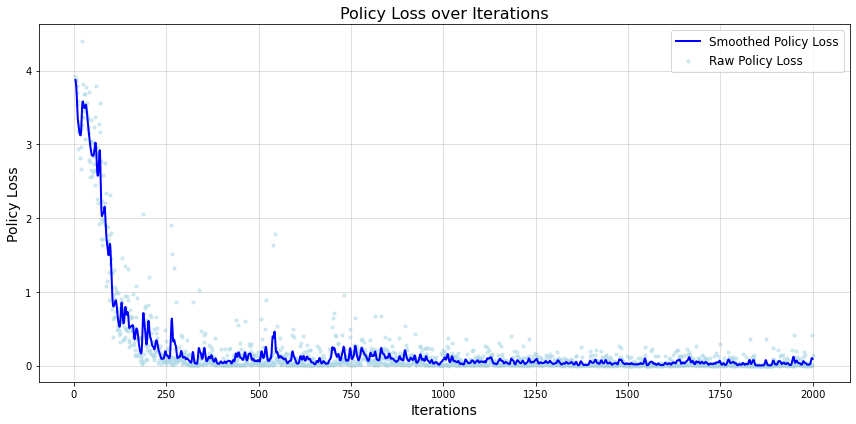

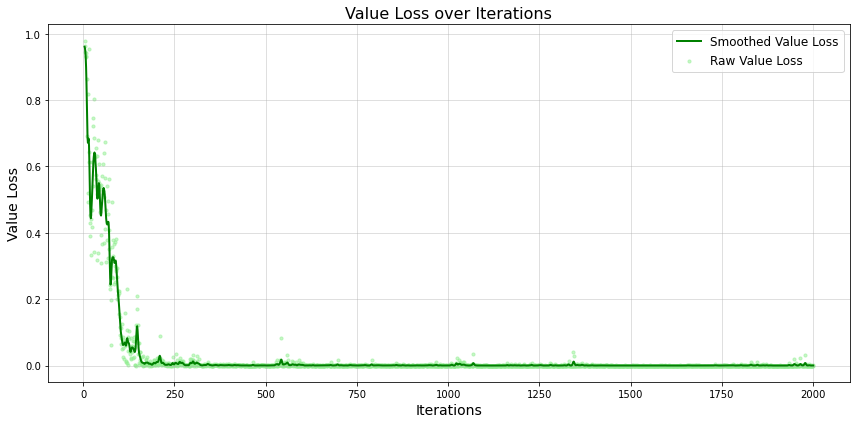

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Read the data
file_path = './training_log/training_log_parsed.csv'  # Update this with the path to your file
data = pd.read_csv(file_path)

# Extract columns
iterations = data['Iteration']
policy_loss = data['Policy Loss']
value_loss = data['Value Loss']

# Smooth the data using a Gaussian filter
smoothed_policy_loss = gaussian_filter1d(policy_loss, sigma=2)
smoothed_value_loss = gaussian_filter1d(value_loss, sigma=2)

# Plot Policy Loss
plt.figure(figsize=(12, 6))
plt.plot(iterations, smoothed_policy_loss, label='Smoothed Policy Loss', color='blue', linewidth=2)
plt.scatter(iterations, policy_loss, label='Raw Policy Loss', color='lightblue', s=10, alpha=0.5)
plt.title('Policy Loss over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Policy Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Value Loss
plt.figure(figsize=(12, 6))
plt.plot(iterations, smoothed_value_loss, label='Smoothed Value Loss', color='green', linewidth=2)
plt.scatter(iterations, value_loss, label='Raw Value Loss', color='lightgreen', s=10, alpha=0.5)
plt.title('Value Loss over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Value Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()